<a href="https://colab.research.google.com/github/hersh-4/Youtube-Webscraping-Project/blob/main/WebScrapingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scrape YouTube Data

In [ ]:
import googleapiclient.discovery
import googleapiclient.errors
import pandas as pd
import time

#API key to access youtube data Api in the secrets section of google colab
from google.colab import userdata
userdata.get('YoutubeAPIkey')

# Set up the API client
api_key = userdata.get('YoutubeAPIkey')
youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)

# Fetch channel's playlist ID
# I am using ConnorEatsPants's channel Id here, any channel should work
channel_request = youtube.channels().list(part="contentDetails", id="UCMNZDz6ga1AOBdHZr8mkCvA")
channel_response = channel_request.execute()
playlist_id = channel_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

# Fetch all videos in the playlist using pagination
video_data = []
next_page_token = None

while True:
    video_request = youtube.playlistItems().list(
        part="snippet",
        playlistId=playlist_id,
        maxResults=50,
        pageToken=next_page_token
    )
    video_response = video_request.execute()

    for item in video_response['items']:
        video_id = item['snippet']['resourceId']['videoId']
        video_request = youtube.videos().list(part="snippet,statistics,contentDetails", id=video_id)
        video_details = video_request.execute()
        video_info = video_details['items'][0]

        title = video_info['snippet']['title']
        views = video_info['statistics'].get('viewCount', 'N/A')
        duration = video_info['contentDetails']['duration']

        video_data.append([title, views, duration])

    # Check if there's another page
    next_page_token = video_response.get('nextPageToken')
    if not next_page_token:
        break  # Exit the loop if no more pages

    time.sleep(1)  # Add a delay to prevent exceeding quota

# Convert to DataFrame
df = pd.DataFrame(video_data, columns=['Title', 'Views', 'Duration'])
print(df)


                                              Title   Views    Duration
0                     🔴 Old ConnorEatsPants is Back    5459  PT3H33M33S
1          🔴 It's Mario Day (Now a Federal Holiday)    4692  PT3H16M30S
2                  The Capital Punishment Tier List   32537    PT32M38S
3       🔴 Ladies... Happy International Women's Day    3579  PT1H34M12S
4                             🔴 Back from the Grave    5082  PT3H24M34S
..                                              ...     ...         ...
879  ConnorEatsPants reacts to his CURSED Subreddit  146234    PT39M38S
880       They added Minecraft Steve to Smash Bros.  162186    PT34M44S
881        I finally finished a Minecraft Speedrun.  124095    PT45M46S
882             The Beginning of Super Mario Galaxy   66360    PT38M40S
883          Losing my mind in Super Mario Bros. 35   34351    PT35M42S

[884 rows x 3 columns]


Save Data to Excel

In [ ]:
workbook = xlsxwriter.Workbook('youtube_data.xlsx')
worksheet = workbook.add_worksheet()

# Write headers
worksheet.write(0, 0, "Title")
worksheet.write(0, 1, "Views")
worksheet.write(0, 2, "Duration")

# Write data
for row, (title, view, dura) in enumerate(video_data, start=1):
    worksheet.write(row, 0, title)
    worksheet.write(row, 1, view)
    worksheet.write(row, 2, dura)

workbook.close()


Data Preprocessing

Cleaning and categorizing Duration

In [ ]:
 !pip install isodate
import isodate

def convert_duration(duration):
    # Parse the ISO 8601 duration
    try:
        parsed_duration = isodate.parse_duration(duration)
        return parsed_duration.total_seconds()
    except:
        return 0  # If parsing fails, return 0

df['Duration'] = df['Duration'].apply(convert_duration)

def categorize_duration(value, title):
  #this is just how connor lables livestreams, other creators may not follow this standard, so this will not be standard for all
    if "🔴" in title:
            return 'Livestream VODs'
    elif value < 60:
        return 'Shorts'
    elif value < 3600:
        return 'Average Videos'
    else:
        return 'Long Videos'

df['Duration_Category'] = df.apply(lambda row: categorize_duration(row['Duration'], row['Title']), axis=1)
df.head()

,Title,Views,Duration,Duration_Category
0,🔴 Old ConnorEatsPants is Back,5459,12813.0,Livestream VODs
1,🔴 It's Mario Day (Now a Federal Holiday),4692,11790.0,Livestream VODs
2,The Capital Punishment Tier List,32537,1958.0,Average Videos
3,🔴 Ladies... Happy International Women's Day,3579,5652.0,Livestream VODs
4,🔴 Back from the Grave,5082,12274.0,Livestream VODs


Cleaning Views

In [ ]:
df['Views'] = df['Views'].astype(str)  # Ensure all values are strings
df['Views'] = df['Views'].str.replace(" views", "", regex=False)  # Remove " views"

def convert_views(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    else:
        return value

df['Views'] = df['Views'].apply(convert_views)
df.head()

,Title,Views,Duration,Duration_Category
0,🔴 Old ConnorEatsPants is Back,5459,12813.0,Livestream VODs
1,🔴 It's Mario Day (Now a Federal Holiday),4692,11790.0,Livestream VODs
2,The Capital Punishment Tier List,32537,1958.0,Average Videos
3,🔴 Ladies... Happy International Women's Day,3579,5652.0,Livestream VODs
4,🔴 Back from the Grave,5082,12274.0,Livestream VODs


Text Preprocessing

In [ ]:
!pip install tqdm
from tqdm import tqdm
import re
import nltk
nltk.download('stopwords')

def preprocess_text(text_data):
    processed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
        words = [word.lower() for word in sentence.split() if word not in stopwords.words('english')]
        processed_text.append(" ".join(words))
    return processed_text

df['Title'] = preprocess_text(df['Title'].values)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 884/884 [00:01<00:00, 632.34it/s]


 Data Visualization

WordCloud for Titles

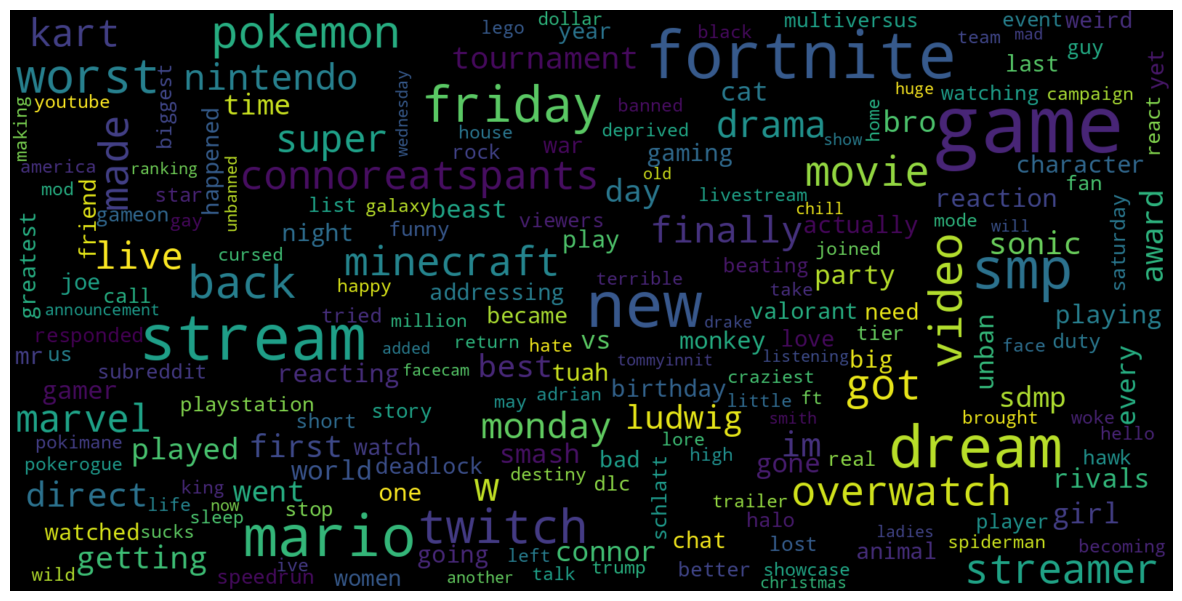

In [ ]:
!pip install wordcloud  # Install if not already installed

from wordcloud import WordCloud
import matplotlib.pyplot as plt

consolidated = ' '.join(df['Title'].astype(str))
wordcloud = WordCloud(width=1600, height=800, max_font_size=110, collocations=False).generate(consolidated)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Countplot for Video Durations

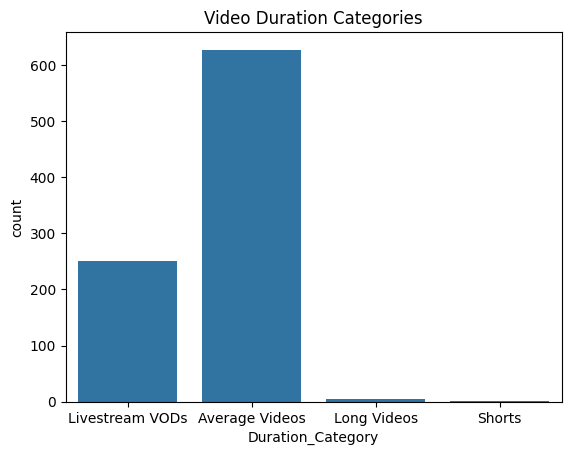

In [ ]:
!pip install seaborn  # Install seaborn if not installed

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['Duration_Category'])
plt.title('Video Duration Categories')
plt.show()
